TIR ./../pytorch-unet/tir_inp3_ds4_stand.ckpt
3DIMG_07NOV2019_2200_L1C_SGP.tif
3DIMG_07NOV2019_2230_L1C_SGP.tif
3DIMG_07NOV2019_2300_L1C_SGP.tif
3DIMG_07NOV2019_2330_L1C_SGP.tif
 Baseline MSE -   1020.4121 UNet MSE -  532.2202
 Baseline MAE -  18.510008 UNet MAE -  14.388066


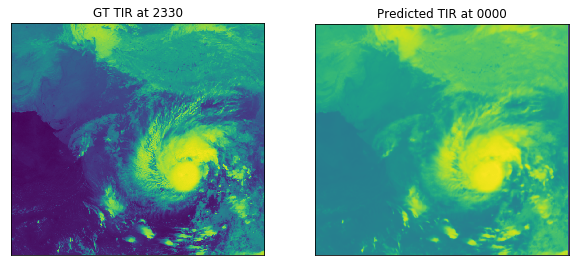

VIS ./../pytorch-unet/vis_inp3_1.ckpt
3DIMG_07NOV2019_2200_L1C_SGP_vis.tif
3DIMG_07NOV2019_2230_L1C_SGP_vis.tif
3DIMG_07NOV2019_2300_L1C_SGP_vis.tif
3DIMG_07NOV2019_2330_L1C_SGP_vis.tif
 Baseline MSE -   8.921081 UNet MSE -  11.687047
 Baseline MAE -  1.7660491 UNet MAE -  1.7651341


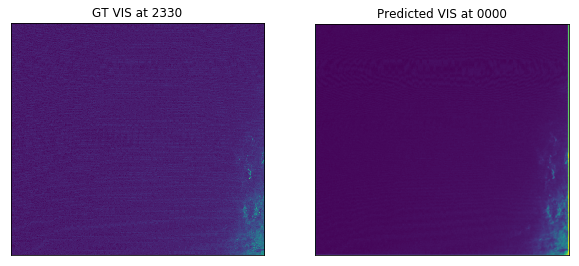

In [12]:
import numpy as np
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./../pytorch-unet/")
sys.path.append("./../utils/")
from pre_processing import get_seq_data


dir_paths = ["./../pytorch-unet/INSAT3D_TIR1_India", "./../pytorch-unet/INSAT3D_VIS_India" ]
print_format = ['TIR','VIS']

inp_seq = 3
pred_frame = 1

#for evaluation
inp =  [ ['3DIMG_07NOV2019_2200_L1C_SGP.tif','3DIMG_07NOV2019_2230_L1C_SGP.tif','3DIMG_07NOV2019_2300_L1C_SGP.tif'],
         ['3DIMG_07NOV2019_2200_L1C_SGP_vis.tif','3DIMG_07NOV2019_2230_L1C_SGP_vis.tif','3DIMG_07NOV2019_2300_L1C_SGP_vis.tif'] ]

target = [ ['3DIMG_07NOV2019_2330_L1C_SGP.tif'],
           ['3DIMG_07NOV2019_2330_L1C_SGP_vis.tif'] ]

# for final output
last_sequence = [ ['3DIMG_07NOV2019_2230_L1C_SGP.tif','3DIMG_07NOV2019_2300_L1C_SGP.tif','3DIMG_07NOV2019_2330_L1C_SGP.tif'],
                    ['3DIMG_07NOV2019_2230_L1C_SGP_vis.tif','3DIMG_07NOV2019_2300_L1C_SGP_vis.tif','3DIMG_07NOV2019_2330_L1C_SGP_vis.tif'] ]



# values calculated on training set
mn,mx = 387.0, 948.0
vmean, vstd = 68.5147950474417, 71.67788656008055

model_paths = ["./../pytorch-unet/tir_inp3_ds4_stand.ckpt", "./../pytorch-unet/vis_inp3_1.ckpt"]
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    



def pre_process(inp,iformat = 'TIR'):
    
    if( iformat=='TIR' ):
        inp = (inp-mn)/(mx-mn)
    else:
        inp = (inp-vmean)/vstd
        
    inp = np.expand_dims(inp,axis=0)
    inp = torch.from_numpy(inp)
    inp = inp.to(device,dtype=torch.float)

    return inp

def post_process(inp,iformat='TIR'):

    if( iformat=='TIR' ):
        inp = inp*(mx-mn) + mn
    else:
        inp = inp*vstd + vmean
    
    return np.squeeze(inp.detach().numpy())
    
for i,dir_path in enumerate(dir_paths):
    print(print_format[i],model_paths[i])
    model = torch.load(model_paths[i],map_location=device)
    model = model.to(device)
    model.eval() 

    
    # get images in numpy array
    img1, img2,gt = [],[],[]
    for j in range(inp_seq):
        img1.append( np.array(Image.open( os.path.join( dir_path, inp[i][j] ) ) ) )
        img2.append( np.array(Image.open( os.path.join( dir_path, last_sequence[i][j] ) ) ) )
        print(inp[i][j])
        
        
    nmn,nmx = np.min(img1), np.max(img1)    
    gt = np.array( Image.open( os.path.join(dir_path,target[i][0]) ) ) 
    latest = np.array( Image.open( os.path.join( dir_path, inp[i][-1] ) ) )   # most recent image for prediction at 2330              
    print(target[i][0])
    
    img1, img2, gt = np.array(img1), np.array(img2), np.array(gt)
    img1 = pre_process(img1,print_format[i])
    img2 = pre_process(img2,print_format[i])
    
 
    output1 = model(img1).cpu()    
    output1 = post_process(output1,iformat=print_format[i])
    
    
    unet_mse = ((output1[:984,:1074]-gt)**2).mean()
    unet_mae =  np.abs( output1[:984,:1074]-gt).mean() 
    
    bmse = ((latest-gt)**2).mean()
    bmae = np.abs(latest-gt).mean()
    
    s_latest = (latest - nmn)/(nmx-mn)
    s_gt = ( gt-nmn )/(nmx-nmn)
    s_output1 = ( output1[:984,:1074]-nmn )/(nmx-nmn)
    
    sunet_mse = ((s_output1[:984,:1074] - s_gt)**2).mean()
    s_bmae =  np.abs( s_output1[:984,:1074] - s_gt ).mean()
    
    output2 = model(img2).cpu()
    output2 = post_process(output2,iformat=print_format[i])
    
    print( " Baseline MSE -  ", bmse,"UNet MSE - ", unet_mse)
    print( " Baseline MAE - ", bmae, "UNet MAE - ", unet_mae )

    Image.fromarray( np.squeeze(output2) ).save( f"optical_flow_8nov_12am_{print_format[i]}.tif" )
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plt.imshow(gt)
    ax.set_title(f"GT {print_format[i]} at 2330")
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plt.imshow(np.squeeze(output2))
    ax.set_title(f"Predicted {print_format[i]} at 0000" )
    
    plt.show()

    